In [1]:
library(forecast)
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Aggregated TS

In [2]:
df_eu  <-  read.csv(file="hts_eu_a10.csv", header=TRUE, sep=",", row.names =1 )

In [3]:
gdp_agg <- df_eu_sums <-  rowSums(df_eu)

In [4]:
gdp_agg %>% head()

2000-01-01 2000-04-01 2000-07-01 2000-10-01 2001-01-01 2001-04-01 
   2097016    2149714    2163305    2249545    2197372    2259781

In [5]:
gdp_agg  <- ts(gdp_agg, frequency = 4, start = 2000) 

In [6]:
train <- window(gdp_agg, end=c(2016,4))
test <- window(gdp_agg, start=c(2017,1))

#### Модель 0: RW with drift

The random walk with drift model is

$$Y_t=c + Y_{t-1} + Z_t$$

``rwf(y, h, drift=TRUE)``

#### Модель 1: Theta

``library(foreast)``

Equivalent to simple exponential smoothing with drift 

$\sim$ ETS(AAdN)

In [7]:
ets(train)

ETS(M,Ad,A) 

Call:
 ets(y = train) 

  Smoothing parameters:
    alpha = 0.972 
    beta  = 0.6358 
    gamma = 0.0042 
    phi   = 0.8 

  Initial states:
    l = 2108703.3746 
    b = 29348.6343 
    s = 43366.96 -8526.152 2324.243 -37165.05

  sigma:  0.0101

     AIC     AICc      BIC 
1688.558 1692.417 1710.753 

In [8]:
auto.arima(train)

Series: train 
ARIMA(2,0,0)(2,1,0)[4] with drift 

Coefficients:
         ar1      ar2     sar1     sar2      drift
      1.4235  -0.5655  -0.3083  -0.4719  18140.750
s.e.  0.0987   0.1006   0.1399   0.1145   3356.515

sigma^2 estimated as 779254753:  log likelihood=-745.74
AIC=1503.48   AICc=1504.95   BIC=1516.43

In [9]:
auto.arima(train, ic='bic')

Series: train 
ARIMA(2,0,0)(2,1,0)[4] with drift 

Coefficients:
         ar1      ar2     sar1     sar2      drift
      1.4235  -0.5655  -0.3083  -0.4719  18140.750
s.e.  0.0987   0.1006   0.1399   0.1145   3356.515

sigma^2 estimated as 779254753:  log likelihood=-745.74
AIC=1503.48   AICc=1504.95   BIC=1516.43

In [10]:
Arima(train, order=c(2,1,2), seasonal=c(2,1,2))

Series: train 
ARIMA(2,1,2)(2,1,2)[4] 

Coefficients:
          ar1      ar2     ma1     ma2     sar1     sar2     sma1    sma2
      -0.7498  -0.4656  1.3089  1.0000  -0.0792  -0.2608  -1.0277  0.0278
s.e.   0.1354   0.1253  0.0795  0.0902   0.4602   0.1355   0.5142  0.4875

sigma^2 estimated as 586803189:  log likelihood=-730.07
AIC=1478.14   AICc=1481.53   BIC=1497.42

In [11]:
gdp_rwf <- rwf(train,h=7)
gdp_rwfwd <- rwf(train,h=7, drift=TRUE)
gdp_snaive  <- snaive(train,h=7)
gdp_theta  <- thetaf(train, h=7)
gdp_arima  <- forecast(Arima(train, order=c(2,1,2), seasonal=c(2,1,2)), h=7)
gdp_auto_arima  <- forecast(auto.arima(train), h=7)
gdp_ets <- forecast(ets(train), h=7)

In [12]:
cat("RW")
accuracy(gdp_rwf, test)[, c(2,5,7,8)]
cat("RW with drift ")
accuracy(gdp_rwfwd, test)[, c(2,5,7,8)]
cat("SNaive")
accuracy(gdp_snaive, test)[, c(2,5,7,8)]
cat("Theta")
accuracy(gdp_theta, test)[, c(2,5,7,8)]
cat("ARIMA")
accuracy(gdp_arima, test)[, c(2,5,7,8)]
cat("Auto ARIMA")
accuracy(gdp_auto_arima, test)[, c(2,5,7,8)]
cat("ETS")
accuracy(gdp_ets, test)[, c(2,5,7,8)]

RW

,RMSE,MAPE,ACF1,Theil's U
Training set,61957.82,1.882082,-0.4830031,NA
Test set,100924.98,2.517203,0.2892763,1.698108


RW with drift 

,RMSE,MAPE,ACF1,Theil's U
Training set,58849.27,1.7150060,-0.4830031,NA
Test set,34776.71,0.8161775,-0.3038002,0.4691468


SNaive

,RMSE,MAPE,ACF1,Theil's U
Training set,108505.4,3.463232,0.8651959,NA
Test set,146043.7,3.858363,0.5407384,2.451424


Theta

,RMSE,MAPE,ACF1,Theil's U
Training set,35986.47,1.041397,0.3294760,NA
Test set,109496.60,2.960996,0.6189463,1.829338


ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,21785.78,0.5747027,0.07492727,NA
Test set,67549.13,1.8853066,0.20566073,1.124845


Auto ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,26002.27,0.7027395,0.01000688,NA
Test set,73355.31,2.0782801,0.34890538,1.210819


ETS

,RMSE,MAPE,ACF1,Theil's U
Training set,26248.54,0.7079164,0.02269934,NA
Test set,115786.51,3.0346545,0.58515778,1.95051


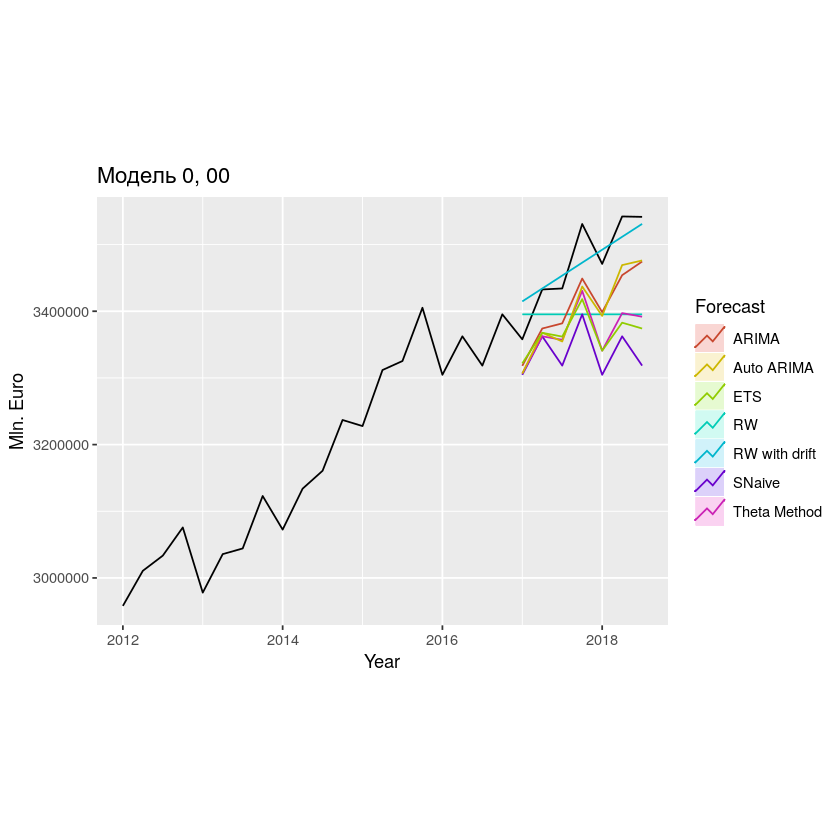

In [13]:
autoplot(window(gdp_agg, start=2012)) +
    autolayer(gdp_rwf, series="RW", PI=FALSE) +
    autolayer(gdp_rwfwd, series="RW with drift", PI=FALSE) +
    autolayer(gdp_snaive, series="SNaive", PI=FALSE) +
    autolayer(gdp_theta, series="Theta Method", PI=FALSE) +
    autolayer(gdp_arima, series="ARIMA", PI=FALSE) +
    autolayer(gdp_auto_arima, series="Auto ARIMA", PI=FALSE) +
    autolayer(gdp_ets, series="ETS", PI=FALSE) +
    xlab("Year") + ylab("Mln. Euro") +
    ggtitle("Модель 0, 00") +
    guides(colour=guide_legend(title="Forecast")) +
    theme(aspect.ratio = 0.75)

### strucchange

In [14]:
library(strucchange)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich



	 Optimal 2-segment partition: 

Call:
breakpoints.Fstats(obj = fs.gdp_agg)

Breakpoints at observation number:
27 

Corresponding to breakdates:
2006(3) 

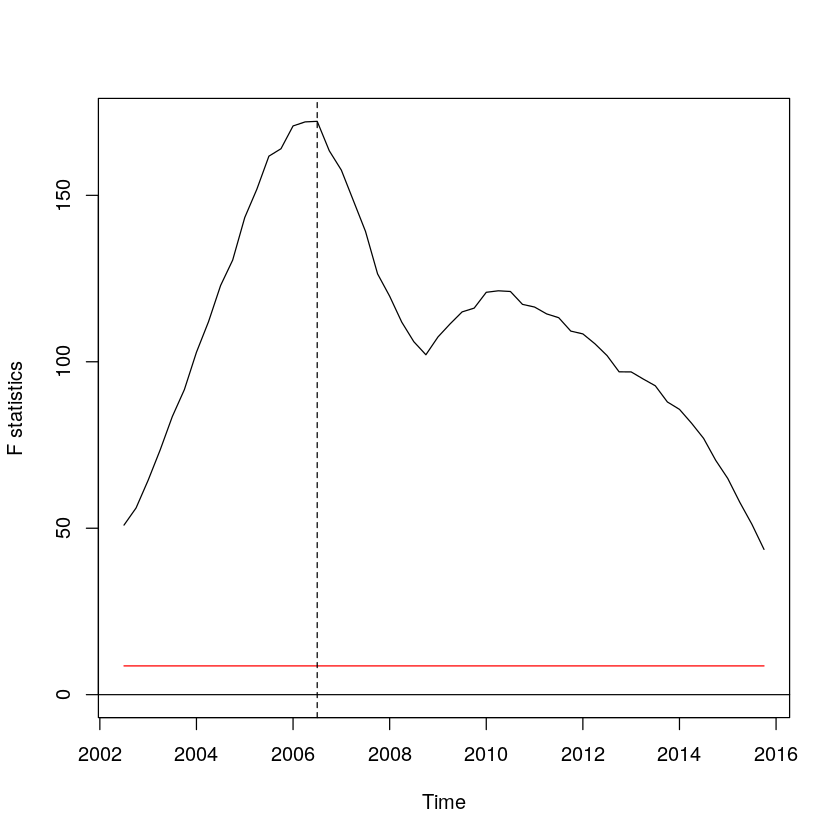

In [15]:
## F statistics indicate one breakpoint
fs.gdp_agg <- Fstats(gdp_agg ~ 1)
plot(fs.gdp_agg)
breakpoints(fs.gdp_agg)
lines(breakpoints(fs.gdp_agg))

In [77]:
stats::lag(gdp_agg, k = -1)


	 Optimal 2-segment partition: 

Call:
breakpoints.Fstats(obj = fs.gdp_agg)

Breakpoints at observation number:
37 

Corresponding to breakdates:
2010(2) 

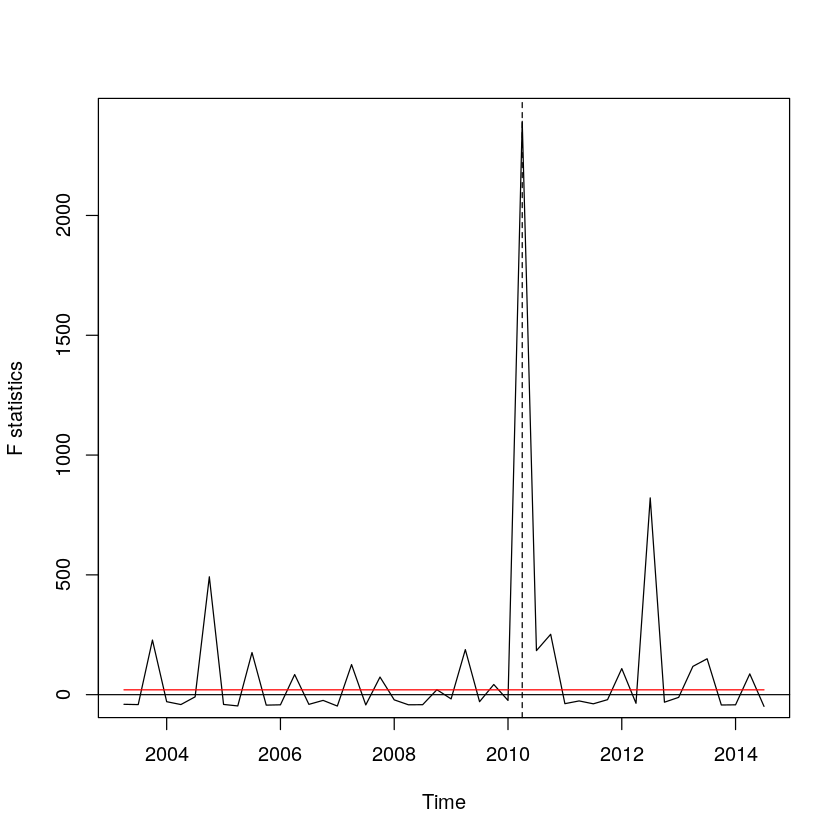

In [24]:
## F statistics indicate one breakpoint
fs.gdp_agg <- Fstats(diff(diff(train),4) ~  1 + stats::lag(diff(diff(train),4), k = -1)  + stats::lag(diff(diff(train),4), k = -2) + stats::lag(diff(diff(train),4), k = -3) + stats::lag(diff(diff(train),4), k = -4) + stats::lag(diff(diff(train),4), k = -8))
plot(fs.gdp_agg)
breakpoints(fs.gdp_agg)
lines(breakpoints(fs.gdp_agg))


	 Optimal 2-segment partition: 

Call:
breakpoints.Fstats(obj = fs.gdp_agg)

Breakpoints at observation number:
29 

Corresponding to breakdates:
2007(1) 

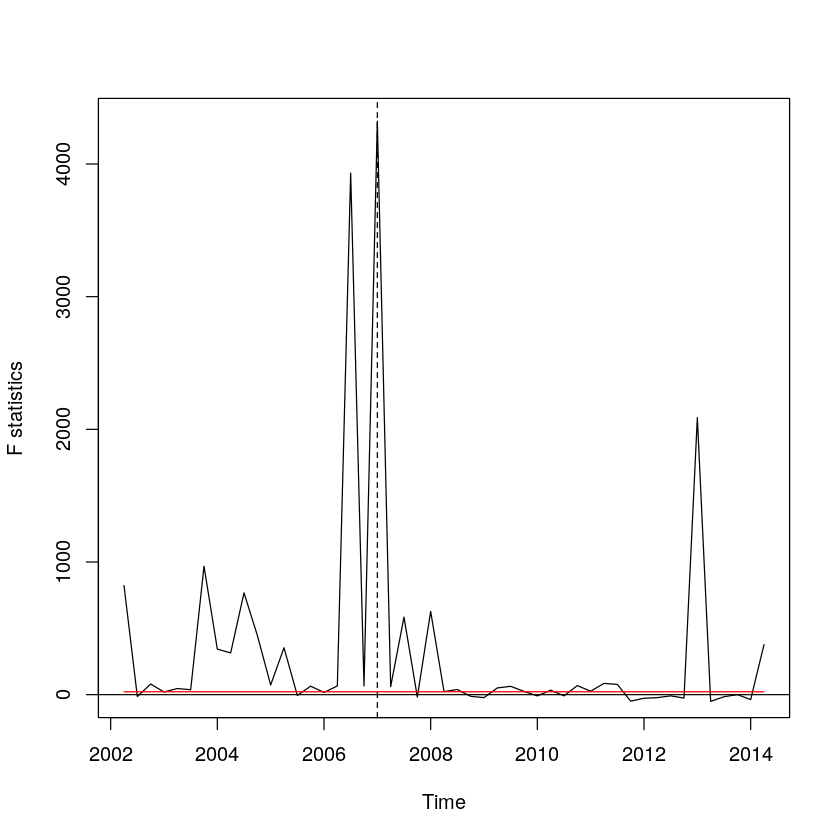

In [44]:
## F statistics indicate one breakpoint
fs.gdp_agg <- Fstats(train  ~  1 + stats::lag(train, k = -1)  
                     + stats::lag(train, k = -2) 
                     + stats::lag(train, k = -3) 
                     + stats::lag(train, k = -4) 
                     + stats::lag(train, k = -8) + time(train))
plot(fs.gdp_agg)
breakpoints(fs.gdp_agg)
lines(breakpoints(fs.gdp_agg))


	 Optimal 2-segment partition: 

Call:
breakpoints.Fstats(obj = fs.gdp_agg)

Breakpoints at observation number:
36 

Corresponding to breakdates:
2008(4) 

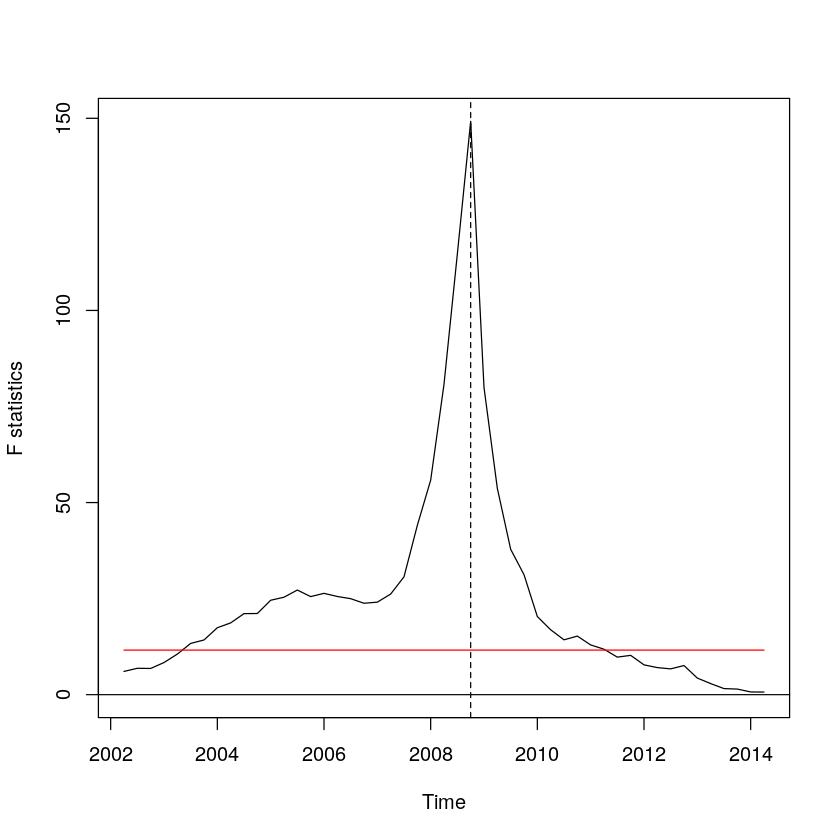

In [46]:
## F statistics indicate one breakpoint
fs.gdp_agg <- Fstats(train  ~  1 + time(train))
plot(fs.gdp_agg)
breakpoints(fs.gdp_agg)
lines(breakpoints(fs.gdp_agg))

In [47]:
breakpoints(fs.gdp_agg)[[1]] 

[1] 36

In [69]:
dum  <-  rep(c(0,1), c(breakpoints(fs.gdp_agg)[[1]], length(gdp_agg) - breakpoints(fs.gdp_agg)[[1]]))
dum2  <-  rep(c(0,1), c(36,length(gdp_agg)-36))

In [73]:
all(dum == dum2)

[1] TRUE

https://www.stat.ncsu.edu/people/bloomfield/courses/st730/slides/R-comments.pdf

In [74]:
library(zoo)

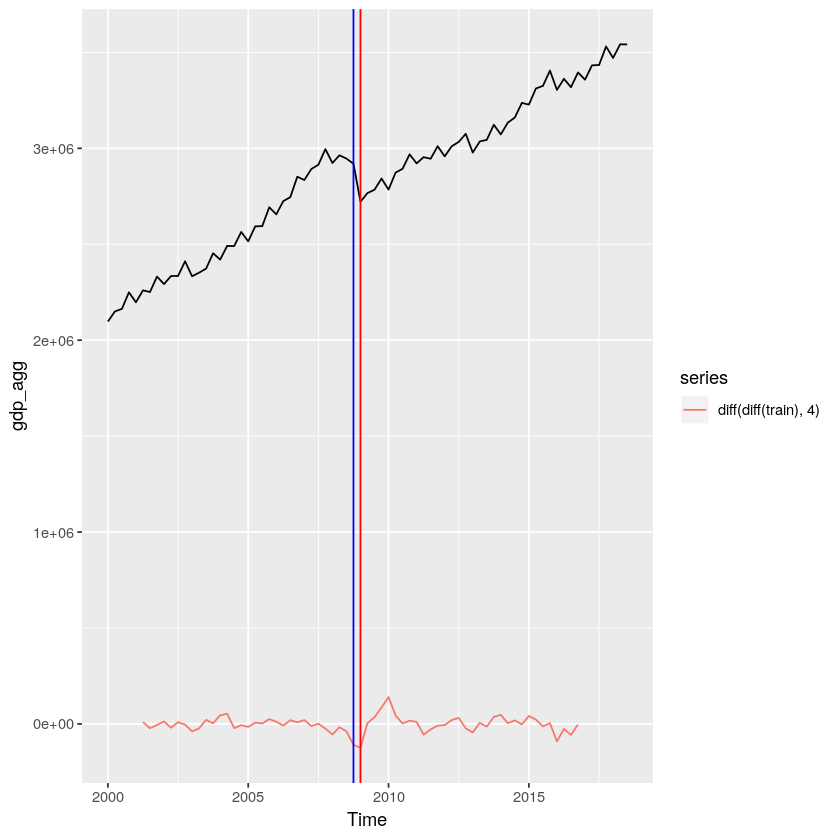

In [75]:
autoplot(gdp_agg) +
    autolayer(diff(diff(train),4)) + 
    geom_vline(xintercept=c(time(gdp_agg)[breakpoints(fs.gdp_agg)[[1]]],time(gdp_agg)[37]), col=c("blue", "red"))

In [76]:
auto.arima(gdp_agg, lambda = 'auto', xreg=dum)

Series: gdp_agg 
Regression with ARIMA(1,1,0)(1,0,0)[4] errors 
Box Cox transformation: lambda= 0.48701 

Coefficients:
         ar1    sar1      xreg
      0.3343  0.9119  -48.8650
s.e.  0.1270  0.0434   11.2794

sigma^2 estimated as 213.4:  log likelihood=-305.53
AIC=619.05   AICc=619.63   BIC=628.27

In [85]:
auto.arima(train)
auto.arima(train, lambda = 'auto', xreg=dum[1:68])
auto.arima(train, lambda = 'auto', xreg=dum2[1:68])

Series: train 
ARIMA(2,0,0)(2,1,0)[4] with drift 

Coefficients:
         ar1      ar2     sar1     sar2      drift
      1.4235  -0.5655  -0.3083  -0.4719  18140.750
s.e.  0.0987   0.1006   0.1399   0.1145   3356.515

sigma^2 estimated as 779254753:  log likelihood=-745.74
AIC=1503.48   AICc=1504.95   BIC=1516.43

Series: train 
Regression with ARIMA(1,1,0)(2,0,0)[4] errors 
Box Cox transformation: lambda= 0.8985424 

Coefficients:
         ar1    sar1    sar2      xreg
      0.4139  0.6570  0.2711  5871.645
s.e.  0.1147  0.1247  0.1273  5562.191

sigma^2 estimated as 55878152:  log likelihood=-694.37
AIC=1398.73   AICc=1399.72   BIC=1409.76

Series: train 
Regression with ARIMA(1,1,0)(2,0,0)[4] errors 
Box Cox transformation: lambda= 0.8985424 

Coefficients:
         ar1    sar1    sar2        xreg
      0.3387  0.5819  0.3629  -25175.140
s.e.  0.1317  0.1281  0.1308    5596.726

sigma^2 estimated as 40829929:  log likelihood=-684.31
AIC=1378.63   AICc=1379.61   BIC=1389.65

In [86]:
gdp_rwfwd <- rwf(train,h=7, drift=TRUE)
gdp_snaive  <- snaive(train,h=7)
gdp_theta  <- thetaf(train, h=7)
gdp_arima  <- forecast(Arima(train, order=c(2,1,2), seasonal=c(2,1,2)), h=7)
gdp_auto_arima  <- forecast(auto.arima(train), h=7)
gdp_str_arima  <- forecast(auto.arima(train, lambda = 'auto', xreg=dum[1:68]), 7, xreg = dum[69:75])
gdp_str2_arima  <-  forecast(auto.arima(train, lambda = 'auto', xreg=dum2[1:68]), 7, xreg = dum2[69:75])
gdp_str3_arima  <- forecast(Arima(train, order=c(2,1,2), seasonal=c(2,1,2), xreg=dum2[1:68]), h=7, xreg = dum2[69:75])

cat("RW with drift ")
accuracy(gdp_rwfwd, test)[, c(2,5,7,8)]
cat("Theta")
accuracy(gdp_theta, test)[, c(2,5,7,8)]
cat("ARIMA")
accuracy(gdp_arima, test)[, c(2,5,7,8)]
cat("ARIMA 2009")
accuracy(gdp_str3_arima, test)[, c(2,5,7,8)]
cat("Auto ARIMA")
accuracy(gdp_auto_arima, test)[, c(2,5,7,8)]
cat("Auto ARIMA str")
accuracy(gdp_str_arima, test)[, c(2,5,7,8)]
cat("Auto ARIMA 2009")
accuracy(gdp_str2_arima, test)[, c(2,5,7,8)]


Warning message in forecast.Arima(Arima(train, order = c(2, 1, 2), seasonal = c(2, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”

RW with drift 

,RMSE,MAPE,ACF1,Theil's U
Training set,58849.27,1.7150060,-0.4830031,NA
Test set,34776.71,0.8161775,-0.3038002,0.4691468


Theta

,RMSE,MAPE,ACF1,Theil's U
Training set,35986.47,1.041397,0.3294760,NA
Test set,109496.60,2.960996,0.6189463,1.829338


ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,21785.78,0.5747027,0.07492727,NA
Test set,67549.13,1.8853066,0.20566073,1.124845


ARIMA 2009

,RMSE,MAPE,ACF1,Theil's U
Training set,20664.46,0.5171513,-0.016175671,NA
Test set,60599.20,1.6938699,-0.007325357,1.014394


Auto ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,26002.27,0.7027395,0.01000688,NA
Test set,73355.31,2.0782801,0.34890538,1.210819


Auto ARIMA str

,RMSE,MAPE,ACF1,Theil's U
Training set,32507.88,0.8879873,0.003907227,NA
Test set,95397.35,2.4864029,0.552919489,1.605391


Auto ARIMA 2009

,RMSE,MAPE,ACF1,Theil's U
Training set,27834.33,0.7382768,-0.04103613,NA
Test set,81958.28,2.1087837,0.55341056,1.379567


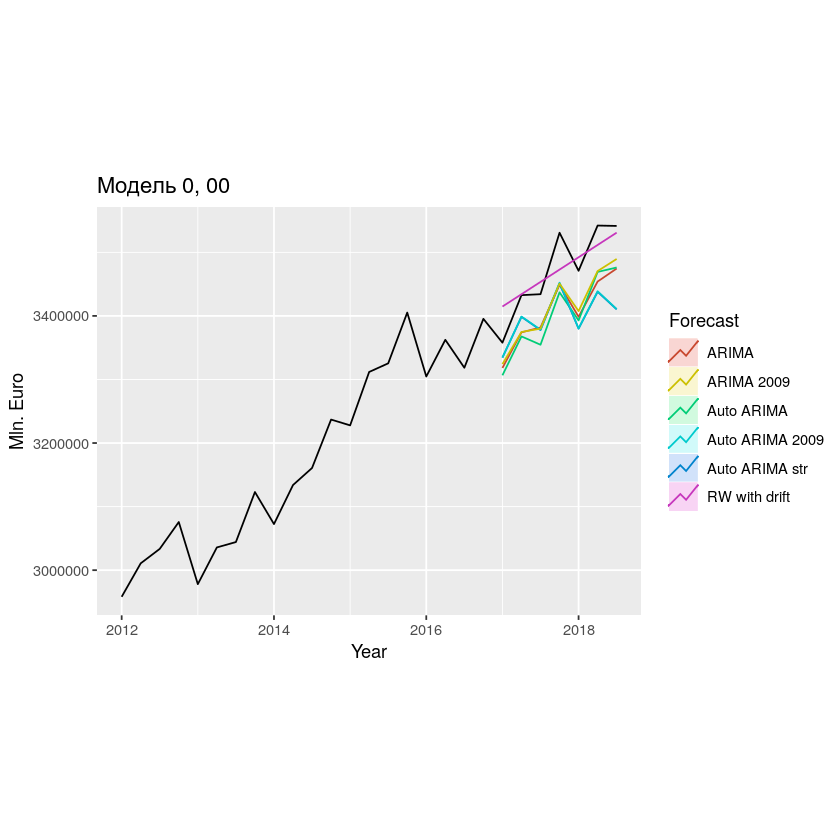

In [43]:
autoplot(window(gdp_agg, start=2012)) +
    autolayer(gdp_rwfwd, series="RW with drift", PI=FALSE) +
    autolayer(gdp_arima, series="ARIMA", PI=FALSE) +
    autolayer(gdp_auto_arima, series="Auto ARIMA", PI=FALSE) +
    autolayer(gdp_str_arima, series="Auto ARIMA str", PI=FALSE) +
    autolayer(gdp_str2_arima, series="Auto ARIMA 2009", PI=FALSE) +
    autolayer(gdp_str3_arima, series="ARIMA 2009", PI=FALSE) +
    xlab("Year") + ylab("Mln. Euro") +
    ggtitle("Модель 0, 00") +
    guides(colour=guide_legend(title="Forecast")) +
    theme(aspect.ratio = 0.75)

In [87]:
## or
bp.gdp_agg <- breakpoints(diff(diff(train),4) ~  1 + stats::lag(diff(diff(train),4), k = -1) + stats::lag(diff(diff(train),4), k = -4))
summary(bp.gdp_agg)


	 Optimal (m+1)-segment partition: 

Call:
breakpoints.formula(formula = diff(diff(train), 4) ~ 1 + stats::lag(diff(diff(train), 
    4), k = -1) + stats::lag(diff(diff(train), 4), k = -4))

Breakpoints at observation number:
                      
m = 1            35   
m = 2         30    47
m = 3   11    29 38   
m = 4   11    29 40 52
m = 5   11 20 29 40 52

Corresponding to breakdates:
                                               
m = 1                           2009(4)        
m = 2                   2008(3)         2012(4)
m = 3   2003(4)         2008(2) 2010(3)        
m = 4   2003(4)         2008(2) 2011(1) 2014(1)
m = 5   2003(4) 2006(1) 2008(2) 2011(1) 2014(1)

Fit:
                                                                     
m   0          1          2          3          4          5         
RSS  3.947e-21  2.268e-21  1.508e-21  1.142e-21  7.559e-22  6.671e-22
BIC -3.025e+03 -3.044e+03 -3.053e+03 -3.054e+03 -3.063e+03 -3.055e+03


	 Optimal 5-segment partition: 

Call:
breakpoints.breakpointsfull(obj = bp.gdp_agg)

Breakpoints at observation number:
11 29 40 52 

Corresponding to breakdates:
2003(4) 2008(2) 2011(1) 2014(1) 

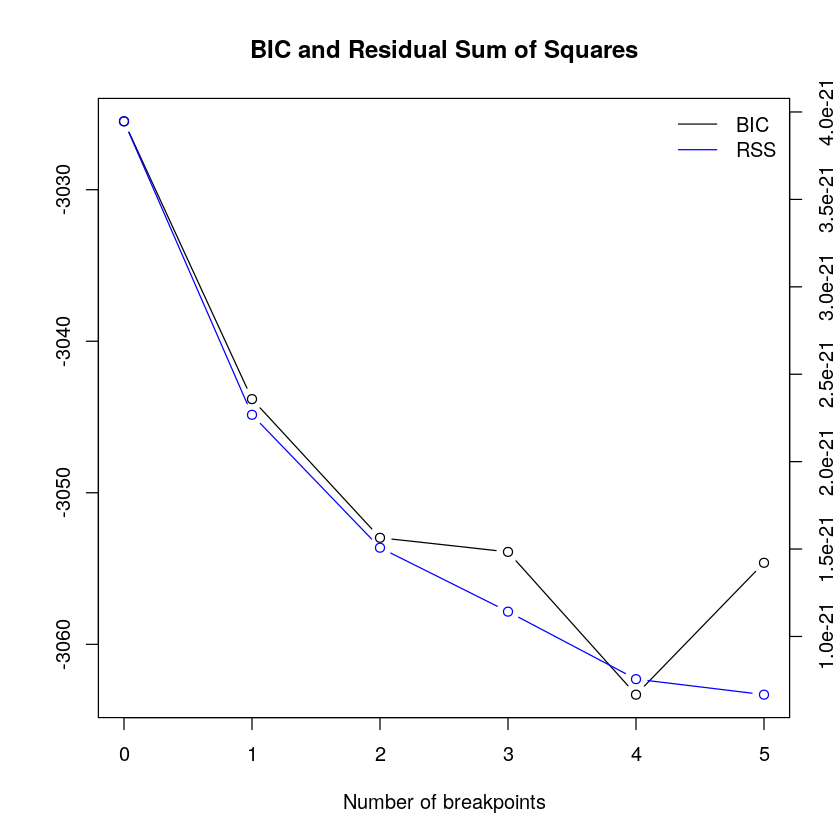

In [88]:
## the BIC also chooses one breakpoint
plot(bp.gdp_agg)
breakpoints(bp.gdp_agg)

In [90]:
## fit null hypothesis model and model with 1 breakpoint
fm0 <- lm(diff(diff(train),4) ~  1 + stats::lag(diff(diff(train),4), k = -1) + stats::lag(diff(diff(train),4), k = -4))
fm1 <- lm(diff(diff(train),4) ~ breakfactor(bp.gdp_agg, breaks = 1))

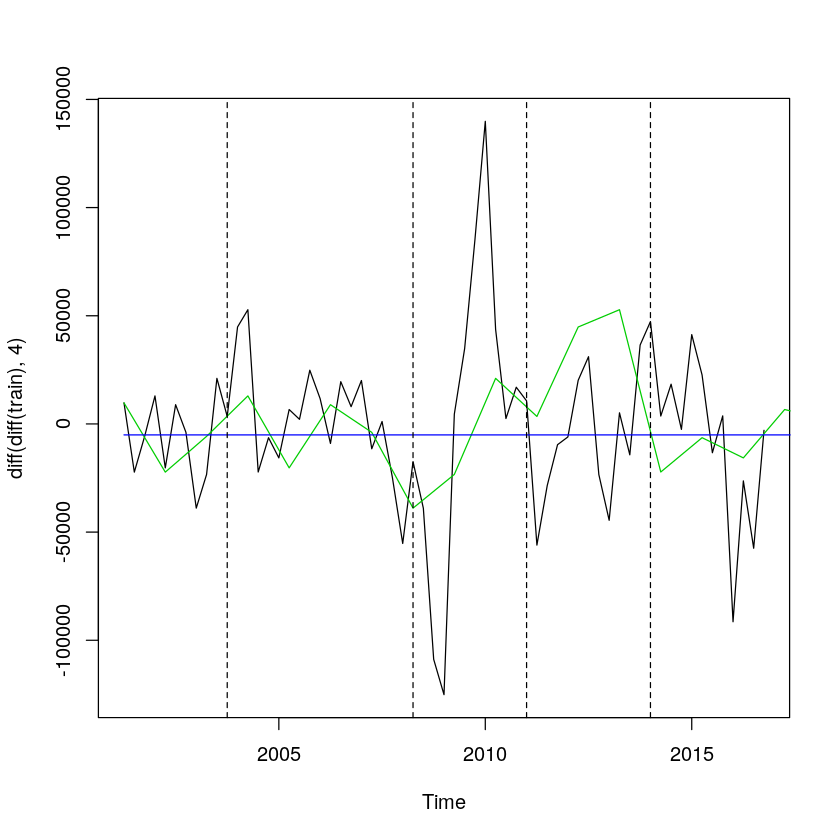

In [96]:
plot(diff(diff(train),4))
lines(ts(fitted(fm0), start = 2001.25), col = 3)
lines(ts(fitted(fm1), start = 2001.25), col = 4)
lines(bp.gdp_agg)